# R-CNN Implementation using Penn-Fudan Pedestrian Dataset

구현 내용:
- 데이터셋 로딩 및 전처리 (Annotation 파일을 파싱하여 이미지 경로와 bounding box 추출)
- Selective Search를 통한 region proposal 생성 및 IoU 기준 라벨링
- PyTorch Dataset 구성 (이미지 crop 및 전처리 적용 후 tensor로 변환)
- 사전 학습된 CNN (VGG16)을 사용한 feature 추출
- scikit-learn의 SGDClassifier/SGDRegressor를 이용한 점진적 학습
- 학습/테스트 데이터 분할 및 결과 시각화


## 1. 라이브러리 및 패키지 임포트

필요한 모든 라이브러리를 임포트함

In [10]:
# OS 관련 함수 및 파일 경로 처리를 위한 모듈
import os

# OpenCV: 이미지 로드 및 전처리를 위한 라이브러리
import cv2

# NumPy: 배열 연산을 위한 라이브러리
import numpy as np

# Selective Search: region proposal 생성에 사용
import selectivesearch

# Pillow: 이미지 파일 입출력을 위한 라이브러리
from PIL import Image

# PyTorch 관련 모듈: 신경망 모델, 텐서 데이터셋, 데이터 로더 등
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 사전 학습된 모델(VGG16) 및 이미지 전처리 관련 모듈
import torchvision.models as models
import torchvision.transforms as T

# 진행률 표시를 위한 tqdm
from tqdm import tqdm

# scikit-learn: 선형 분류 및 회귀 모델 (SGD 기반) 사용
from sklearn.linear_model import SGDClassifier, SGDRegressor

# 데이터 분할을 위한 모듈 (train/test split)
from sklearn.model_selection import train_test_split

# 시각화: matplotlib
import matplotlib.pyplot as plt

# 정규표현식: 텍스트 파일 파싱에 사용
import re

## 2. Data Utils: 데이터 로딩 및 전처리 함수 정의

Penn-Fudan Pedestrian 데이터셋은 Annotation 폴더에 있는 텍스트 파일을 통해 각 이미지의 경로와 보행자 bounding box 정보를 제공함

아래 함수는 텍스트 파일을 읽어 필요한 정보를 파싱함

In [11]:
def load_penn_fudan_data(root_dir):
    """
    Penn-Fudan Pedestrian 데이터셋의 Annotation 폴더 내 텍스트 파일을 읽어,
    각 이미지 파일 경로와 보행자 객체의 bounding box 정보를 추출함

    텍스트 파일에는 이미지 파일 경로, 이미지 크기, 객체 수 및 각 객체의 bounding box 정보 등이 포함됨
    예시:
      Image filename : "PennFudanPed/PNGImages/FudanPed00001.png"
      Bounding box for object 1 "PASpersonWalking" (Xmin, Ymin) - (Xmax, Ymax) : (160, 182) - (302, 431)
    """
    annotation_dir = os.path.join(root_dir, "Annotation")  # Annotation 폴더 경로 설정
    data_list = []  # 최종 데이터 정보를 저장할 리스트
    
    # Annotation 폴더 내의 모든 텍스트 파일들을 정렬하여 가져옴
    txt_files = sorted([f for f in os.listdir(annotation_dir) if f.endswith('.txt')])
    
    # 각 텍스트 파일을 순회하며 파싱
    for txt_file in txt_files:
        txt_path = os.path.join(annotation_dir, txt_file)
        with open(txt_path, 'r') as f:
            lines = f.readlines()  # 파일 전체 라인을 읽어옴
        
        img_path = None  # 이미지 경로 초기화
        boxes = []       # bounding box들을 저장할 리스트
        labels = []      # 각 객체의 라벨 (여기서는 보행자이므로 모두 1로 설정)
        
        # 파일의 각 줄을 확인하며 필요한 정보를 추출함
        for line in lines:
            line = line.strip()  # 양쪽 공백 제거
            
            # "Image filename" 라인이 있으면 이미지 파일 경로를 추출
            if line.startswith("Image filename"):
                m = re.search(r'Image filename\s*:\s*"([^"]+)"', line)
                if m:
                    img_path = m.group(1)  # 따옴표 안의 경로 추출
            
            # "Bounding box for object" 라인을 찾고, 정규표현식으로 네 개의 좌표를 추출
            if line.startswith("Bounding box for object"):
                m = re.search(
                    r'Bounding box for object \d+ ".*?" \(Xmin, Ymin\) - \(Xmax, Ymax\) : \((\d+),\s*(\d+)\) - \((\d+),\s*(\d+)\)',
                    line
                )
                if m:
                    x_min = int(m.group(1))  # Xmin 좌표 추출
                    y_min = int(m.group(2))  # Ymin 좌표 추출
                    x_max = int(m.group(3))  # Xmax 좌표 추출
                    y_max = int(m.group(4))  # Ymax 좌표 추출
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(1)  # 모든 보행자 객체는 클래스 1로 라벨링
        
        # 이미지 경로와 하나 이상의 bounding box가 추출된 경우, data_list에 추가
        if img_path is not None and boxes:
            data_list.append({
                'img_path': img_path,
                'boxes': boxes,
                'labels': labels
            })
    
    return data_list

# Selective Search를 통한 region proposal 생성을 위한 함수
def get_region_proposals(img, scale=100, min_size=200):
    """
    입력 이미지(img)를 RGB로 변환한 후, Selective Search 알고리즘을 이용하여
    region proposal(후보 영역)들을 생성함
    scale과 min_size 파라미터는 후보 영역의 크기와 세부 설정을 조정함
    """
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR 이미지를 RGB로 변환
    _, regions = selectivesearch.selective_search(img_rgb, scale=scale, min_size=min_size)
    # scale 세그먼트의 크기를 조정하는 파라미터 (값이 클수록 더 큰 영역을 생성)
    # min_size	최소 영역 크기 (이 값보다 작은 영역은 제거됨)
    proposals = []
    for r in regions:
        x, y, w, h = r['rect']
        if w == 0 or h == 0:
            continue  # 유효하지 않은 영역은 건너뜀
        proposals.append({'x': x, 'y': y, 'w': w, 'h': h})
    return proposals

def iou(boxA, boxB):
    """
    두 박스(boxA, boxB) 사이의 Intersection over Union (IoU)를 계산함
    IoU는 두 박스의 교집합 면적을 합집합 면적으로 나눈 값으로, 0~1 사이의 값을 가짐
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)  # 교집합 면적 계산
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)  # IoU 계산 (0으로 나누는 것을 방지하기 위해 작은 값을 추가함)

def build_rcnn_entries(data_list):
    """
    R-CNN 학습을 위한 데이터 엔트리를 생성하는 함수.

    이 함수는 각 이미지에 대해 Selective Search를 수행하여 Region Proposal(후보 영역)을 생성한 후,
    각 후보 영역과 ground truth bounding box 간의 IoU(Intersection over Union)를 계산한다.
    
    - IoU가 0.5 이상이면 해당 후보 영역을 **보행자(Positive, 1)** 로 라벨링.
    - IoU가 0.5 미만이면 **배경(Negative, 0)** 으로 라벨링.
    
    각 후보 영역에 대해 (이미지 id, 후보 영역 좌표, 라벨, target bounding box) 정보를 entry로 생성하고,
    최종적으로 RCNN 학습을 위한 데이터셋을 구성한다.

    Parameters:
    -----------
    data_list : list of dict
        - 각 이미지의 정보가 담긴 리스트.
        - 각 딕셔너리는 아래와 같은 키를 가짐:
            * 'img_path' (str) : 이미지 파일 경로
            * 'boxes' (list of list) : 보행자(ground truth) 바운딩 박스 좌표 목록
              (예: [[x_min, y_min, x_max, y_max], [x_min, y_min, x_max, y_max], ...])
    
    Returns:
    --------
    images : list of numpy.ndarray
        - OpenCV를 이용해 로드한 이미지 배열 리스트.
    
    all_entries : list of dict
        - RCNN 학습을 위한 엔트리 데이터 리스트.
        - 각 엔트리는 다음과 같은 정보를 포함:
            * 'img_id' (int) : 이미지 ID (data_list에서의 인덱스)
            * 'region' (tuple) : 후보 영역의 좌표 (x_min, y_min, width, height)
            * 'label' (int) : 라벨 (1 = 보행자, 0 = 배경)
            * 'target_box' (list) : 해당 후보 영역과 가장 IoU가 높은 ground truth 박스 
                                    (배경일 경우 [0, 0, 0, 0])

    주요 과정:
    ----------
    1. 데이터셋의 각 이미지에 대해:
        - OpenCV를 사용하여 이미지를 로드하고 리스트에 저장.
        - Selective Search를 이용해 후보 영역(Region Proposal)을 생성.
    
    2. 각 후보 영역에 대해:
        - Ground Truth 바운딩 박스들과 IoU를 계산.
        - IoU가 가장 높은 GT 박스를 찾고, 0.5 이상이면 보행자(1), 그렇지 않으면 배경(0)으로 라벨링.
    
    3. 최종적으로 RCNN 학습에 필요한 엔트리 데이터를 리스트에 저장하여 반환.

    """
    images = []
    all_entries = []
    
    # 데이터셋의 각 항목에 대해
    for i, item in enumerate(tqdm(data_list, desc="Building R-CNN entries")):
        img_path = item['img_path']
        gt_boxes = item['boxes']
        img = cv2.imread(img_path)  # OpenCV를 이용하여 이미지 로드
        images.append(img)  # 로드된 이미지를 리스트에 저장함
        if img is None:
            continue  # 이미지 로드 실패 시 건너뜀
        
        # 해당 이미지에서 region proposal을 생성함
        proposals = get_region_proposals(img, scale=100, min_size=200)
        
        # 각 후보 영역에 대해
        for prop in tqdm(proposals, desc="Proposals", leave=False):
            x1p = prop['x']
            y1p = prop['y']
            x2p = x1p + prop['w']
            y2p = y1p + prop['h']
            prop_box = [x1p, y1p, x2p, y2p]
            
            best_iou = 0.0
            best_box = None
            # ground truth 박스들과 후보 영역의 IoU를 계산함
            for gbox in gt_boxes:
                val = iou(prop_box, gbox)
                if val > best_iou:
                    best_iou = val
                    best_box = gbox
            
            # IoU가 0.5 이상이면 보행자(클래스 1), 그렇지 않으면 배경(클래스 0)으로 라벨 지정함
            if best_iou >= 0.5:
                lbl = 1
                tbox = best_box
            else:
                lbl = 0
                tbox = [0, 0, 0, 0]
            
            # 각 후보 영역에 대해, 이미지 id, 후보 영역 좌표, 라벨, 그리고 target bounding box 정보를 entry로 생성함
            entry = {
                'img_id': i,
                'region': (prop['x'], prop['y'], prop['w'], prop['h']),
                'label': lbl,
                'target_box': tbox
            }
            all_entries.append(entry)
    
    return images, all_entries

class RCNNProposalsDataset(Dataset):
    """
    PyTorch Dataset 클래스임. 각 entry에 대해,
    - 해당 이미지의 region crop을 수행하고,
    - 이미지 전처리(transform)를 적용하여 tensor로 변환함
    """
    def __init__(self, images, entries, transform=None):
        self.images = images
        self.entries = entries
        # transform이 제공되지 않은 경우 기본 transform 사용 (이미지 리사이즈, 텐서 변환, 정규화)
        if transform is None:
            self.transform = T.Compose([
                T.Resize((224, 224)),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform
    
    def __len__(self):
        return len(self.entries)  # 전체 entry의 수 반환
    
    def __getitem__(self, idx):
        e = self.entries[idx]
        img_id = e['img_id']
        x, y, w, h = e['region']
        label = e['label']
        tbox = e['target_box']
        
        # 해당 이미지에서 지정된 영역을 crop함
        img_bgr = self.images[img_id]
        crop = img_bgr[y:y+h, x:x+w, :]
        
        # OpenCV의 BGR을 RGB로 변환한 후 Pillow 이미지로 변환함
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(crop_rgb)
        
        # transform 적용: 리사이즈, 텐서 변환, 정규화 후 tensor로 변환
        tensor_img = self.transform(pil_img)
        
        # 반환: crop된 이미지 tensor, 해당 영역의 라벨, 그리고 bounding box 정보 (float32 타입)
        return tensor_img, label, np.array(tbox, dtype=np.float32)


## 3. Model Utils: Feature Extraction 및 학습 함수 정의

사전 학습된 VGG16 모델을 feature extractor로 사용하고,
SGDClassifier와 4개의 SGDRegressor를 통해 각 후보 영역에 대해 분류와 bounding box 회귀 학습을 수행함

In [12]:
def get_feature_extractor(device='cuda'):
    """
    사전 학습된 VGG16 모델을 불러와서, 마지막 Fully Connected 레이어를 제거한 후
    4096차원의 feature vector를 추출하는 feature extractor로 변환
    """
    vgg16 = models.vgg16(pretrained=True)  # ImageNet으로 사전 학습된 VGG16 로드
    
    # VGG16의 classifier에서 마지막 FC 레이어를 제거하여 4096 차원의 feature 추출
    vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])
    vgg16.eval()  # 추론 모드로 설정 (dropout 등 비활성화)
    vgg16.to(device)  # 모델을 지정한 device (GPU 또는 CPU)로 이동
    return vgg16

def train_rcnn_sgd(dataset, batch_size=64, n_epochs=5):
    """
    주어진 데이터셋에 대해, PyTorch DataLoader를 사용하여 배치 단위로 이미지를 불러오고,
    사전 학습된 feature extractor (VGG16)를 통해 feature를 추출한 후,
    scikit-learn의 SGDClassifier와 각 좌표별 SGDRegressor로 점진적 학습을 수행함

    - SGDClassifier는 힌지 손실(hinge loss)을 사용하여 선형 분류를 수행함
    - warm_start=True 옵션을 사용하여 이전 학습 결과를 유지하며, 여러 배치에 걸쳐 모델을 업데이트함
    """
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    feature_extractor = get_feature_extractor(device)

    # SGDClassifier 설정: 힌지 손실, L2 정규화, 한 에포크당 한 번 업데이트, warm_start 활성화
    cls = SGDClassifier(loss='hinge', penalty='l2', max_iter=1, warm_start=True)

    # 회귀 문제를 위해 4개의 SGDRegressor 생성 (bounding box의 각 좌표에 대해 개별 모델 학습)
    reg_models = [SGDRegressor(penalty='l2', max_iter=1, warm_start=True) for _ in range(4)]

    # 전체 데이터셋에서 추출한 라벨 목록을 이용해 클래스 집합 구성
    all_labels = [dataset[i][1] for i in range(len(dataset))]
    classes = np.unique(all_labels)

    # 지정한 에포크 수 만큼 반복
    for epoch in range(n_epochs):
        pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{n_epochs}")
        for batch_img, batch_lbl, batch_box in pbar:
            # 배치 이미지 텐서를 device(GPU/CPU)로 이동
            batch_img = batch_img.to(device)
            
            # 추론 단계: torch.no_grad()를 사용하여 기울기 계산 없이 feature를 추출함
            with torch.no_grad():
                feat = feature_extractor(batch_img)  # 결과: (B, 4096) 형태의 feature 벡터
            
            # GPU에 있던 텐서를 CPU로 옮기고, NumPy 배열로 변환 (scikit-learn 모델 사용을 위해)
            feat = feat.cpu().numpy()

            # 배치 라벨 및 bounding box 데이터를 NumPy 배열로 변환함
            batch_lbl = np.array(batch_lbl)
            batch_box = np.array(batch_box)  # shape: (B, 4)

            # SGDClassifier를 사용하여 분류 모델 업데이트 (partial_fit: 온라인 학습 방식)
            cls.partial_fit(feat, batch_lbl, classes=classes)

            # 각 bounding box 좌표별로 4개의 회귀 모델을 업데이트함
            for j in range(4):
                # batch_box[:, j]는 현재 배치의 j번째 좌표 (예: x_min, y_min 등)를 나타내는 1차원 배열
                reg_models[j].partial_fit(feat, batch_box[:, j])
    
    return cls, reg_models, feature_extractor

def evaluate_and_visualize(test_images, test_entries, test_data_list,
                           cls_model, reg_models, feature_extractor,
                           transform=None, num_images=5):
    """
    테스트 이미지에 대해, 후보 영역마다 feature를 추출한 후,
    분류 및 회귀 예측을 수행함

    예측된 bounding box와 ground truth bounding box를 원본 이미지에 오버레이하여 시각화함
    """
    from collections import defaultdict
    
    # transform이 지정되지 않은 경우 기본 transform 설정 (학습 시와 동일)
    if transform is None:
        transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    # 이미지별로 후보 영역(entry)을 그룹화 (img_id 기준)
    proposals_by_image = defaultdict(list)
    for entry in test_entries:
        proposals_by_image[entry['img_id']].append(entry)

    device = next(feature_extractor.parameters()).device
    selected_ids = list(proposals_by_image.keys())[:num_images]  # 시각화할 이미지 수 선택

    for img_id in selected_ids:
        img = test_images[img_id].copy()  # 원본 이미지를 복사
        proposals = proposals_by_image[img_id]
        if len(proposals) == 0:
            continue

        feats = []
        valid_entries = []
        
        # 각 후보 영역에 대해
        for entry in proposals:
            x, y, w, h = entry['region']
            crop = img[y:y+h, x:x+w, :]
            if crop.size == 0:
                continue  # 잘못된 영역인 경우 건너뜀
            
            # crop된 영역을 RGB로 변환한 후 Pillow 이미지로 변환함
            crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(crop_rgb)
            
            # transform 적용 후 배치 차원을 추가 (1, 3, 224, 224)
            tensor_img = transform(pil_img).unsqueeze(0)
            tensor_img = tensor_img.to(device)
            
            # feature extractor를 사용하여 후보 영역의 feature 추출 (역전파 없이 수행)
            with torch.no_grad():
                feat_val = feature_extractor(tensor_img)  # (1, 4096) 형태
            
            # 추출된 feature를 NumPy 배열로 변환하여 리스트에 저장함
            feats.append(feat_val.cpu().numpy().squeeze(0))
            valid_entries.append(entry)

        if len(feats) == 0:
            continue
        feats = np.array(feats)

        # 분류 모델의 decision_function 및 예측 결과 얻음
        scores = cls_model.decision_function(feats)
        preds = cls_model.predict(feats)

        # 분류 결과가 1(보행자)로 예측된 후보 영역만 선택함
        valid_idx = [i for i, p in enumerate(preds) if p == 1]
        if len(valid_idx) == 0:
            continue
        valid_scores = scores[valid_idx]
        valid_feats = feats[valid_idx]
        valid_entries = [valid_entries[i] for i in valid_idx]

        # 회귀 모델을 사용하여 각 후보 영역에 대해 bounding box 좌표 예측
        pred_boxes = []
        for feat_val in valid_feats:
            coords = []
            for j in range(4):
                # 각 회귀 모델은 bounding box의 j번째 좌표(x_min, y_min, x_max, y_max)를 예측함
                coords.append(reg_models[j].predict(feat_val.reshape(1, -1))[0])
            pred_boxes.append(coords)

        # 예측 점수가 높은 후보 영역 상위 5개 선택함
        sorted_idx = np.argsort(valid_scores)[-5:]
        top_pred_boxes = [pred_boxes[i] for i in sorted_idx]

        # 원본 이미지에 ground truth bounding box (녹색)와 예측 bounding box (빨간색) 그리기
        gt_item = test_data_list[img_id]
        gt_boxes = gt_item['boxes']
        for box in gt_boxes:
            x1, y1, x2, y2 = box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 녹색 사각형 그리기
        for box in top_pred_boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # 빨간색 사각형 그리기

        # 시각화를 위해 BGR 이미지를 RGB로 변환한 후 Matplotlib으로 출력함
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb)
        plt.title(f"Test Image ID: {img_id}")
        plt.axis('off')
        plt.show()


## 4. Main: 전체 파이프라인 실행

전체 데이터셋을 로딩한 후, 학습/테스트 데이터로 분할하고, R-CNN의 전체 파이프라인(데이터 전처리 → 학습 → 평가 및 시각화)을 실행함

In [18]:
root_dir = "PennFudanPed"
load_penn_fudan_data(root_dir)

[{'img_path': 'PennFudanPed/PNGImages/FudanPed00001.png',
  'boxes': [[160, 182, 302, 431], [420, 171, 535, 486]],
  'labels': [1, 1]},
 {'img_path': 'PennFudanPed/PNGImages/FudanPed00002.png',
  'boxes': [[68, 93, 191, 380]],
  'labels': [1]},
 {'img_path': 'PennFudanPed/PNGImages/FudanPed00003.png',
  'boxes': [[293, 135, 447, 421]],
  'labels': [1]},
 {'img_path': 'PennFudanPed/PNGImages/FudanPed00004.png',
  'boxes': [[168, 60, 324, 338], [9, 61, 48, 180]],
  'labels': [1, 1]},
 {'img_path': 'PennFudanPed/PNGImages/FudanPed00005.png',
  'boxes': [[188, 59, 320, 336], [2, 53, 40, 158]],
  'labels': [1, 1]},
 {'img_path': 'PennFudanPed/PNGImages/FudanPed00006.png',
  'boxes': [[208, 108, 346, 385], [2, 108, 87, 384]],
  'labels': [1, 1]},
 {'img_path': 'PennFudanPed/PNGImages/FudanPed00007.png',
  'boxes': [[112, 69, 218, 346], [378, 76, 529, 377], [317, 108, 347, 192]],
  'labels': [1, 1, 1]},
 {'img_path': 'PennFudanPed/PNGImages/FudanPed00008.png',
  'boxes': [[228, 158, 370, 436]

전체 이미지 수: 170
학습 이미지: 136 테스트 이미지: 34


Building R-CNN entries:   0%|          | 0/136 [00:00<?, ?it/s]c:\Users\hopio\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
Building R-CNN entries: 100%|██████████| 34/34 [00:23<00:00,  1.45it/s]
c:\Users\hopio\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hopio\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `w

학습 프로포절: 48359 테스트 프로포절: 12819


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\hopio/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:48<00:00, 11.4MB/s] 
Epoch 5/5: 100%|██████████| 756/756 [01:33<00:00,  8.13it/s]


학습 완료.


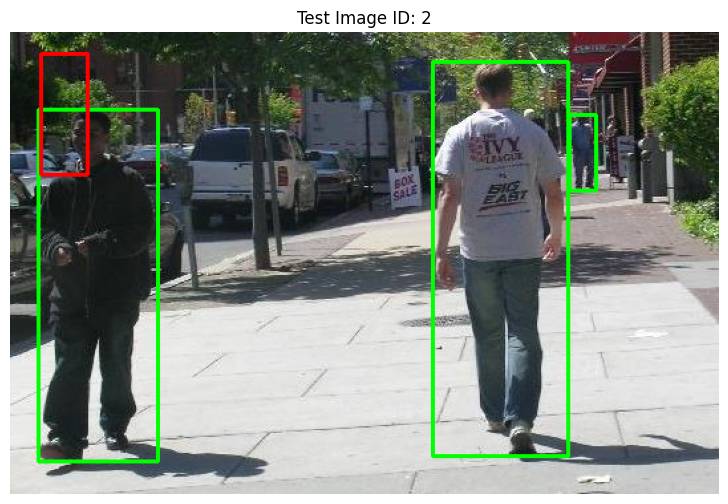

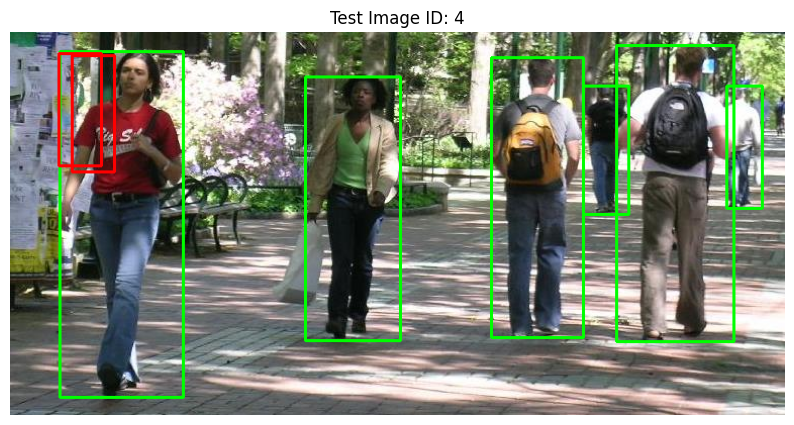

In [13]:
def main():
    # 데이터셋 루트 경로 설정
    root_dir = "PennFudanPed"
    
    # Penn-Fudan 데이터셋의 Annotation 파일을 파싱하여 이미지 경로와 bounding box 정보를 추출함
    data_list = load_penn_fudan_data(root_dir)
    print("전체 이미지 수:", len(data_list))
    
    # 학습과 테스트 데이터로 분할 (예: 80% 학습, 20% 테스트)
    train_data_list, test_data_list = train_test_split(data_list, test_size=0.2, random_state=42)
    print("학습 이미지:", len(train_data_list), "테스트 이미지:", len(test_data_list))
    
    # 학습 데이터에 대해, R-CNN entry 생성: 각 이미지에 대해 region proposal 생성 및 IoU 기준 라벨링함
    train_images, train_entries = build_rcnn_entries(train_data_list)
    # 테스트 데이터에 대해서도 동일하게 entry 생성 (평가 및 시각화용)
    test_images, test_entries = build_rcnn_entries(test_data_list)
    print("학습 프로포절:", len(train_entries), "테스트 프로포절:", len(test_entries))
    
    # PyTorch Dataset 생성: 이미지 crop과 transform 적용 후 tensor로 변환함
    train_dataset = RCNNProposalsDataset(train_images, train_entries)
    
    # 학습 수행: SGDClassifier와 4개의 SGDRegressor를 사용하여 feature에 기반한 점진적 학습 수행
    cls_model, reg_models, cnn_model = train_rcnn_sgd(train_dataset, batch_size=64, n_epochs=5)
    print("학습 완료.")
    
    # 테스트 결과 시각화: 테스트 이미지의 후보 영역에 대해 예측 결과와 ground truth를 비교하여 출력함
    evaluate_and_visualize(test_images, test_entries, test_data_list,
                           cls_model, reg_models, cnn_model, num_images=5)

if __name__ == "__main__":
    main()
